In [1]:
import random
import numpy as np
import Parsing_midi as pm
import Init_chromo as init
import count_CE as ce
import mido
from mido import Message, MidiFile, MidiTrack
from collections import Counter
import copy

from itertools import combinations # product: 排列

/home/hsuan/env1/lib/python3.6/site-packages/pydub/utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
"""
## import function

- Parsing_midi
    - get_midi
    - get_pitch
    - parse_midi
    - separate_phrase

- Init_chromo
    - shift_note
    - merge_duplicate_note
    - extend_duration
"""
print()

### Seperate phrase
- one bar = 1920 (4 beats)
- sliding window = 7680 (4 bar)
- Parameters:
    - base
    - midi list
    - threshold

In [3]:
midi_list = pm.get_midi('MidiSample/sky.mid',0)

## seperate input into 4 bar
def separate_song(song, threshold):
    a = song
    time = 0; t = []; t2 = []; n = []; n2 = []
    for i in range(len(a)):
        time += a[i].time 
        if time <= threshold:
#             time += a[i].time       
            t.append(a[i])
            n.append(a[i].note%12)
            
        else:
            t2.append(t)  # sepatate bar
            n2.append(n)  # index of note
            ## reset
            time = 0 
            t = []
            n = []
            time += a[i].time
            t.append(a[i])
            n.append(a[i].note%12)
    return n2, t2

In [4]:
## get midi message
pitch_ary = [[0,1,0], [0,-1,2], [0,1,4], [-1,0,11], [1,0,1], [-1,0,3],[1,0,5]]

pitch_ary = np.array(pitch_ary)

def pitch_trans(seq):
    pitch_list = ['C','D','E','F','G','A','B']
    return pitch_list[seq]

def get_key(CE, pitch_ary):
    key = []
    for i in range(len(pitch_ary)):
        key.append(abs(pitch_ary[i][0]-int(CE[0])) + abs(pitch_ary[i][1]-int(CE[1])) + \
                  abs(pitch_ary[i][2]-int(CE[2])))
    predict_key = pitch_trans(key.index(min(key)))
    return predict_key

def trans_note_list(song):
    note_list=[]
    for i in range(len(song)):
        note_list.append(song[i].note)
    return note_list

note_msg, midi_msg = separate_song(midi_list, 1920)

_parent = midi_msg[0:3]  # change here for testing

In [25]:
parent = _parent[1]
parent

[<message note_on channel=0 note=75 velocity=0 time=719>,
 <message note_on channel=0 note=74 velocity=113 time=1>,
 <message note_on channel=0 note=74 velocity=0 time=239>,
 <message note_on channel=0 note=75 velocity=113 time=1>,
 <message note_on channel=0 note=75 velocity=0 time=479>,
 <message note_on channel=0 note=79 velocity=113 time=1>,
 <message note_on channel=0 note=79 velocity=0 time=479>,
 <message note_on channel=0 note=74 velocity=113 time=1>]

In [26]:
## transform to C major
for i in range(len(parent)):
    parent[i].note = parent[i].note -7 # shift
    
to_midi_file(parent,8 , 'ori.mid')

True

### Evolutionary algorithmn
- selection
- crossover
- mutation
- fitness

In [27]:
## Initialize (at least 50)
pop1 = init.shift_note(parent, 4)             # 移調
pop2 = init.shift_note(parent, 7)             # 移調
pop3 = parent                                 # 原曲
pop4 = init.merge_duplicate_note(parent)      # 重複的切分音直接轉為連音
pop5 = init.change_duration(parent, 120, 480, 3) # 延長音 16分音符->一拍
pop6 = init.change_duration(parent, 240, 120, 3) # 縮短音 8分音符->16分音符
pop_list = [pop1, pop2, pop3, pop4, pop5, pop6]

In [28]:
## Selection
"""
Parameter:
pop_list
candidate
"""
def select_best(pop_list, chord):
    pop_idx=[]
    for i in range(len(pop_list)):
        pop_idx.append(i)    #目前是5個initial choromosome
        
    candidate = list(combinations(pop_idx, 2))

    scr = []; mid = []
    for i in range(len(candidate)):
        individual1, individual2 = pop_list[candidate[i][0]], pop_list[candidate[i][1]]
        note1 = trans_note_list(individual1)
        note2 = trans_note_list(individual2)
        _score1, _midi1 = fitness(individual1, note1, chord)
        _score2, _midi2 = fitness(individual2, note2, chord)
        scr.append(_score1 + _score2)
        mid.append([_midi1,_midi2])
    scr_ary = np.array(scr)
    top2 = int(scr_ary.argsort()[-1:])
    return mid[top2][0], mid[top2][1], scr[top2]  # 回傳分數最高的一組candidate


## Crossover
"""
Parameter:
crossover_rate
crossover_point
"""
def crossover(parent, pop):
#     print("crossover...")
    crossover_point = random.randint(0,len(parent))
    while crossover_point % 2 != 0 :
        crossover_point = random.randint(0,len(parent))
    pop_midi1 = parent[ :crossover_point] + pop[crossover_point: ]
    pop_midi2 = pop[ :crossover_point] + parent[crossover_point: ]
    return pop_midi1, pop_midi2
 
    
## Mutation
"""
Parameter:
mute_rate
mute_point
mutate_list
"""
def mutation(child):  
    mute_point = random.randint(0,len(child)-1)  #選擇一點做突變
    while mute_point % 2 != 0:
        mute_point = random.randint(0,len(child)-1)
    mutate_note = np.random.choice(7, 1, replace=False, p=[0.2, 0.2, 0.25, 0.05, 0.25, 0.025, 0.025]) #突變之機率
    # mutate_list = [child[mute_point].note + int(mutate_note), 0]  #選擇突變或是直接刪除  ##TODO: 相加後可能超過12->跨一八度
    if child[mute_point].note < 120:
        child[mute_point].note = child[mute_point].note + int(mutate_note)
        child[mute_point + 1].note = child[mute_point].note
    else:
        child[mute_point].note = child[mute_point].note - int(mutate_note)
        child[mute_point + 1].note = child[mute_point].note
    return child
   
    
## Evaluation
"""
fitness function
pitch
chord
"""
## base on CE get the chord name 
chord_list = [[0,4,7], [2,5,9], [4,7,11], [5,9,0], [7,11,2], [9,0,4], [11,2,5]]
pitch_list = ['C','D','E','F','G','A','B']

def fitness(midi_msg, note_msg, chord): # type: list
#     print("fitness evaluate...")
    score = 0
    scale_list = [0,2,4,5,7,9,11]
    
    ## Get first and last note
    first_note = midi_msg[0].note
    last_note = midi_msg[-1].note
    
#     # get chord (by CE) -> get note -> match
#     key = get_key(note_msg, pitch_ary)
#     chord = chord_list[pitch_list.index(key)]
        
    ## Pitch
    for i in range(len(midi_msg) - 2):
        if i < len(midi_msg)-2 and abs(midi_msg[i].note - midi_msg[i+2].note) == 4: ## major third
            score += 4
#             print("abs(midi_msg[i].note - midi_msg[i+1].note)==4")
        if i < len(midi_msg)-2 and abs(midi_msg[i].note - midi_msg[i+2].note) == 7: ## perfect fifth
            score += 4
#             print("abs(midi_msg[i].note - midi_msg[i+1].note) == 7")
        if i < len(midi_msg)-2 and abs(midi_msg[i].note - midi_msg[i+2].note) > 7:  ## big jump note
            score = score - 8      
#             print("abs(midi_msg[i].note - midi_msg[i+1].note) > 7")
        if midi_msg[i].note % 12 == chord[0]:## chord root note
            score += 6
#             print("midi_msg[i].note % 12 == chord[0]")
        if midi_msg[i].note % 12 == chord[1]:## 2nd note
            score += 5
#             print("midi_msg[i].note % 12 == chord[1]")
        if midi_msg[i].note % 12 == chord[2]:## 3rd note
            score += 5
#             print("midi_msg[i].note % 12 == chord[2]")
        if i == 0 and midi_msg[i].note % 12 == chord[0]:
            score += 6
#             print("midi_msg[i].note == first_note and midi_msg[i].note % 12 == chord[0]")
        if i == 0 and midi_msg[i].note % 12 == chord[1]:
            score += 4
#             print("midi_msg[i].note == first_note and midi_msg[i].note % 12 == chord[1]")
        if i == 0 and midi_msg[i].note % 12 == chord[2]:
            score += 4
#             print("midi_msg[i].note == first_note and midi_msg[i].note % 12 == chord[2]")
        if i == 0 and midi_msg[i].note % 12 not in chord: # not in chord note
            score -= 2   
#             print("midi_msg[i].note == first_note and midi_msg[i].note % 12 not in chord")
        if i == len(midi_msg) and midi_msg[i].note % 12 == chord[0]:
            score += 6
#             print("midi_msg[i].note == last_note and midi_msg[i].note % 12 == chord[0]")
        if i == len(midi_msg) and midi_msg[i].note % 12 == chord[1]:
            score += 4
#             print("midi_msg[i].note == last_note and midi_msg[i].note % 12 == chord[1]")
        if i == len(midi_msg) and midi_msg[i].note % 12 == chord[2]:
            score += 4
#             print("midi_msg[i].note == last_note and midi_msg[i].note % 12 == chord[2]")
        if i == len(midi_msg) and midi_msg[i].note % 12 not in chord: # not in chord note
            score -= 3
#             print("midi_msg[i].note == last_note and midi_msg[i].note % 12 not in chord")
        if midi_msg[i].note % 12 not in chord: # note is not a chord note
            score -= 3
#             print("midi_msg[i].note % 12 not in chord")
        if midi_msg[i].note % 12 not in scale_list:  # note not in the scale
            score -= 6
#             print("midi_msg[i].note % 12 not in scale_list")
        i += 2
            
    return score, midi_msg

In [29]:
# from pyknon.genmidi import Midi
# from pyknon.music import NoteSeq
# notes1 = NoteSeq("D4 F#8 A Bb4")
# midi = Midi(1, tempo=90)
# midi.seq_notes(notes1, track=0)
# midi.write("demo.mid")

# midi_list = pm.get_midi('demo.mid',0)
# midi_list

In [30]:
%%time
## MAIN
MUTATION_RATE = 0.6
CROSSOVER_RATE = 0.7
GENERATIONS = 200
count = 0; score_list = []; midi_list = []

score_list = []; temp = []


# test 
# key = get_key(trans_note_list(parent), pitch_ary)
# chord = chord_list[pitch_list.index(key)]
# print(chord)
chord = [0,4,7]
    
    
# choose 2 best candidate
parent, pop, scr1 = select_best(pop_list, chord)
score_list.append(scr1)


while count < GENERATIONS:
    candidate_list = []
  
    # crossover, mutation * N
    for i in range(150):  
        # crossover
        crossover_rate = round(random.uniform(0, 1),1)
        if crossover_rate < CROSSOVER_RATE:
            crossover_c1, crossover_c2 = crossover(parent, pop)
        else:
            crossover_c1 = parent 
            crossover_c2 = pop
            
        # mutation
        mute_rate = round(random.uniform(0, 1),1)    
        if mute_rate < MUTATION_RATE:    
            mutation_c1 = mutation(crossover_c1)
            mutation_c2 = mutation(crossover_c2)
        else:
            mutation_c1 = crossover_c1
            mutation_c2 = crossover_c2
        
        candidate_list.append(mutation_c1)
        candidate_list.append(mutation_c2)
        
    # select best 2    
    ## TODO
    parent, pop, scr2 = select_best(candidate_list, chord)
    score_list.append(scr2)
        
    count += 1
#     print("count: ", count)
    print(scr2)
    
print("Finish")

-28
-88
-72
-28
-28
-36
40
-72
8
32
-36
12
-28
-88
-4
-36
48
-28
-36
-12
48
8
-20
-64
-112
-52
12
-12
-36
-64
-72
-40
-40
-48
-112
-40
-48
-48
-40
-88
-112
-52
-40
-28
-88
-28
-120
-40
-28
-72
-32
4
12
-88
-12
-48
-20
-4
-36
-28
-32
-48
40
-40
-88
-88
-64
-72
-4
-112
-88
-88
56
24
-48
-12
-12
-24
20
32
-28
-88
-72
-88
-12
-12
-36
-56
28
-12
-88
-12
-40
-28
-88
-72
48
-8
32
-64
-112
-36
-64
-12
-88
-36
-112
-36
8
-40
-88
-36
-72
-16
-88
-72
-28
-12
-12
-72
-88
-28
-72
-96
24
-96
24
-36
-24
-72
-72
-88
-4
44
-12
-4
-4
-40
24
-20
-52
-52
-28
-88
-52
-4
-52
-64
-36
4
12
-88
-12
84
48
-112
-12
-112
-40
-28
4
-112
-64
-128
-64
28
-64
40
-12
-4
-28
-112
-28
-36
-28
48
24
-64
-88
-24
-12
-4
36
12
-112
-88
-88
-64
-40
-28
-88
-64
-72
-48
-4
-64
-4
-52
-40
12
Finish
CPU times: user 3min 55s, sys: 196 ms, total: 3min 55s
Wall time: 3min 55s


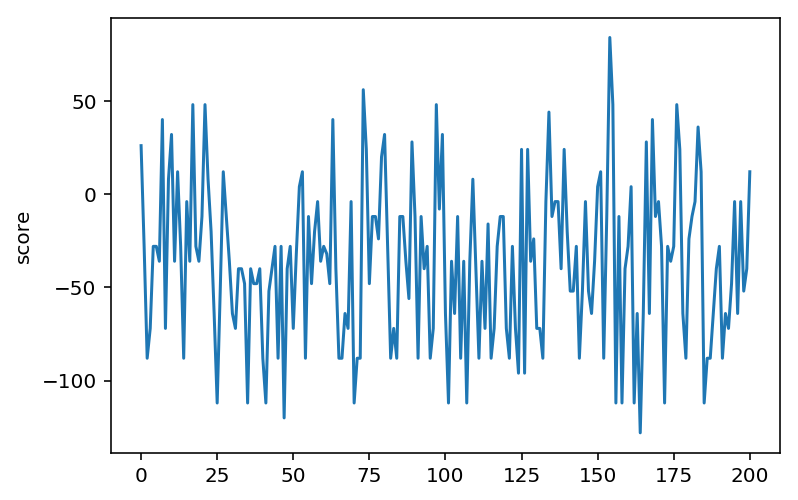

In [31]:
import matplotlib.pyplot as plt
plt.plot(score_list)
plt.ylabel('score')
plt.show()

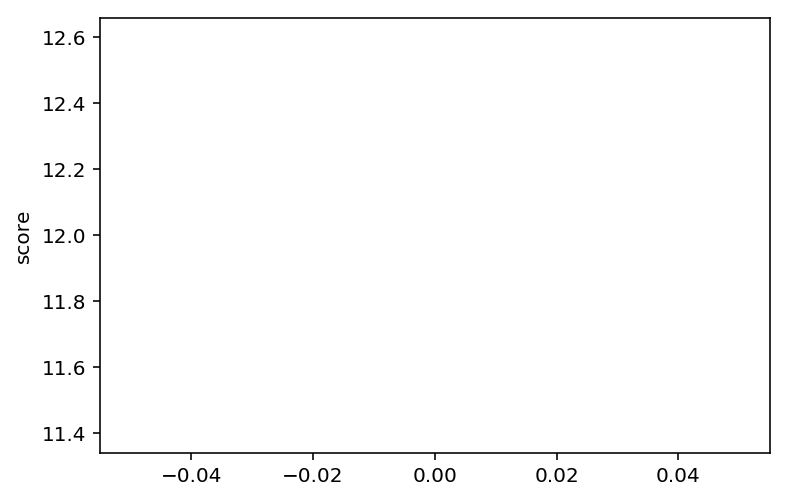

In [12]:
import matplotlib.pyplot as plt
plt.plot(score_list)
plt.ylabel('score')
plt.show()

### Output to midi file

In [13]:
def to_midi_file(inputfile, program, outputfile):
    ## initialize
    mid = MidiFile()
    track = MidiTrack()
    mid.tracks.append(track)
    ## add message
    track.append(Message('program_change', program=program, time=0))
    for i in range(len(inputfile)):
        track.append(Message('note_on', note=inputfile[i].note, velocity=inputfile[i].velocity, time=inputfile[i].time))
    mid.save(outputfile)
    return True

In [16]:
to_midi_file(midi_list[1], 16, 't.mid')

True

---